In [1]:
import pandas as pd
import numpy as np
import os
import sys
import torch
from torch.utils.data import Dataset
sys.path.append(os.path.abspath(".."))

## Load and Split the data

In [2]:
from utils.loader import load_data_with_logReturn

data_clean = load_data_with_logReturn("../stocks/AAPL.csv")

In [3]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11182 entries, 1980-12-22 to 2025-05-02
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close       11182 non-null  float64
 1   Close           11182 non-null  float64
 2   High            11182 non-null  float64
 3   Low             11182 non-null  float64
 4   Open            11182 non-null  float64
 5   Volume          11182 non-null  int64  
 6   LogReturn       11182 non-null  float64
 7   LogReturn_Lag1  11182 non-null  float64
 8   LogReturn_Lag2  11182 non-null  float64
 9   LogReturn_Lag3  11182 non-null  float64
 10  LogReturn_Lag4  11182 non-null  float64
 11  LogReturn_Lag5  11182 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.1 MB


Feature Engineering for the input layer. Now set the slide window size for 10 days, i.e 10x10 = 100 neurons.

In [4]:
class MLP_Dataset(Dataset):
    def __init__(self, df, window, stride):
        self.window = window
        self.stride = stride
        self.X, self.y = self.create_features(df)

    def create_features(self, df):
        X_list, y_list = [], []
        for i in range(self.window, len(df) - 1, self.stride):
            window_data = df.iloc[i-self.window:i][[
                "Open", "High", "Low", "Close", "Volume",
                "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3", "LogReturn_Lag4", "LogReturn_Lag5"
            ]].values  

            flat_window = window_data.flatten()
            X_list.append(flat_window) 
            y_list.append(df["LogReturn"].iloc[i+1])  # or LogReturn, etc.

        X_array = np.array(X_list)
        y_array = np.array(y_list)
        return torch.tensor(X_array, dtype=torch.float32), torch.tensor(y_array, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
batch_size = 8
window = 50
stride=50

# Normailize data
feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
                "LogReturn_Lag4", "LogReturn_Lag5"]

scaler = StandardScaler()
data_clean_scaler = data_clean.copy()
data_clean_scaler[feature_cols] = scaler.fit_transform(data_clean_scaler[feature_cols])

# Assume data_clean is already prepared
dataset = MLP_Dataset(data_clean_scaler, window, stride)

print(len(dataset))

223


In [6]:
def get_indices_by_date_range(sample_end_dates, start_date, end_date, name=""):
    indices = [
        i for i, date in enumerate(sample_end_dates)
        if start_date <= date <= end_date
    ]
    if len(indices) == 0:
        print(f"[Warning] No {name} samples in interval: {start_date.date()} ~ {end_date.date()}")
    return indices


In [7]:
dataset[0]

(tensor([-0.4863, -0.4862, -0.4861, -0.4861, -0.8263,  2.0773,  0.9898,  0.8432,
         -2.7263, -1.9227, -0.4861, -0.4861, -0.4860, -0.4860, -0.7976,  1.6617,
          2.0771,  0.9897,  0.8432, -2.7256, -0.4860, -0.4860, -0.4858, -0.4859,
         -0.7944,  1.4422,  1.6616,  2.0770,  0.9896,  0.8432, -0.4858, -0.4858,
         -0.4856, -0.4856, -0.7718,  1.7954,  1.4421,  1.6615,  2.0766,  0.9896,
         -0.4857, -0.4857, -0.4855, -0.4856, -0.6594,  3.1078,  1.7952,  1.4420,
          1.6612,  2.0764, -0.4858, -0.4858, -0.4856, -0.4857, -0.7320,  0.4723,
          3.1076,  1.7951,  1.4417,  1.6611, -0.4859, -0.4859, -0.4857, -0.4857,
         -0.8311, -0.8964,  0.4722,  3.1074,  1.7948,  1.4417, -0.4858, -0.4858,
         -0.4857, -0.4857, -0.8732, -1.0481, -0.8965,  0.4721,  3.1066,  1.7946,
         -0.4859, -0.4859, -0.4857, -0.4858, -0.8311,  0.3638, -1.0481, -0.8965,
          0.4722,  3.1063, -0.4860, -0.4860, -0.4859, -0.4859, -0.8029, -0.8032,
          0.3637, -1.0482, -

In [8]:
# Get all timestamps from the original DataFrame
all_dates = data_clean.index.tolist()

# Determine the ending date of each sample (starts from index=10 due to window)
sample_end_dates = [
    all_dates[i] for i in range(window, len(data_clean) - 1, stride)
]  # offset by window size


In [9]:

# Define date boundaries for each split
train_val_test_start = pd.Timestamp("1980-01-01")
train_val_test_end = pd.Timestamp("2024-12-31")

main_indices = get_indices_by_date_range(
    sample_end_dates, train_val_test_start, train_val_test_end, "train/val/test"
)


In [10]:
main_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [11]:
import random

random.seed(42)
random.shuffle(main_indices)

In [12]:
total = len(main_indices)
train_end = int(total * 0.7)
val_end = int(total * 0.85)

train_indices = main_indices[:train_end]
val_indices = main_indices[train_end:val_end]
test_indices = main_indices[val_end:]


In [13]:
total = len(main_indices)
train_end = int(total * 0.7)
val_end = int(total * 0.85)

train_indices = main_indices[:train_end]
val_indices = main_indices[train_end:val_end]
test_indices = main_indices[val_end:]

# Create subsets
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

y_train = data_clean["LogReturn"].iloc[[window + i + 1 for i in train_indices]].values
y_val   = data_clean["LogReturn"].iloc[[window + i + 1 for i in val_indices]].values
y_test  = data_clean["LogReturn"].iloc[[window + i + 1 for i in test_indices]].values


In [14]:
val_indices

[168,
 17,
 49,
 147,
 92,
 158,
 160,
 75,
 141,
 20,
 96,
 31,
 137,
 117,
 11,
 67,
 198,
 88,
 91,
 24,
 97,
 202,
 211,
 86,
 201,
 39,
 186,
 87,
 205,
 178,
 40,
 1,
 71]

In [15]:
# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [16]:
print("Number of samples:", len(dataset))
print("Input feature shape:", dataset[0][0].shape)
print("Target value:", dataset[0][1])

Number of samples: 223
Input feature shape: torch.Size([500])
Target value: tensor(-0.0097)


## Model

Define MLP Model

In [17]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        return x


Training

In [18]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = MLP(input_size=train_set.dataset.X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
from tqdm import tqdm

epochs = 20
best_val_loss = float("inf")
best_model_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        progress_bar.set_postfix(loss=avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device).unsqueeze(1)
            val_outputs = model(X_val_batch)
            loss = criterion(val_outputs, y_val_batch)
            val_loss += loss.item() * X_val_batch.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict()

if best_model_state is not None:
            model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 0.003133, Val Loss: 0.002254


Epoch 2, Train Loss: 0.002295, Val Loss: 0.001551


Epoch 3, Train Loss: 0.001536, Val Loss: 0.000943


Epoch 4, Train Loss: 0.000796, Val Loss: 0.000889


Epoch 5, Train Loss: 0.000697, Val Loss: 0.000857


Epoch 6, Train Loss: 0.000734, Val Loss: 0.000900


Epoch 7, Train Loss: 0.000654, Val Loss: 0.000980


Epoch 8, Train Loss: 0.000414, Val Loss: 0.000876


Epoch 9, Train Loss: 0.000513, Val Loss: 0.000883


Epoch 10, Train Loss: 0.000351, Val Loss: 0.000915


Epoch 11, Train Loss: 0.000386, Val Loss: 0.000789


Epoch 12, Train Loss: 0.000337, Val Loss: 0.000836


Epoch 13, Train Loss: 0.000361, Val Loss: 0.000939


Epoch 14, Train Loss: 0.000355, Val Loss: 0.000891


Epoch 15, Train Loss: 0.000342, Val Loss: 0.001009


Epoch 16, Train Loss: 0.000377, Val Loss: 0.000769


Epoch 17, Train Loss: 0.000499, Val Loss: 0.000891


Epoch 18, Train Loss: 0.000381, Val Loss: 0.001210


Epoch 19, Train Loss: 0.000458, Val Loss: 0.000886


Epoch 20, Train Loss: 0.000362, Val Loss: 0.000903


In [20]:
from sklearn.metrics import r2_score, root_mean_squared_error

if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("[Warning] best_model_state is None — using current model weights.")

model.eval()
preds_train, preds_val, preds_test = [], [], []

with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_train.extend(y_pred.cpu().numpy().flatten())

    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_val.extend(y_pred.cpu().numpy().flatten())

    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_test.extend(y_pred.cpu().numpy().flatten())

y_train_pred = np.array(preds_train)
y_val_pred   = np.array(preds_val)
y_test_pred  = np.array(preds_test)


# Print evaluation metrics
print({
    "Train R2": r2_score(y_train, y_train_pred),
    "Val R2": r2_score(y_val, y_val_pred),
    "Test R2": r2_score(y_test, y_test_pred),
    "Train RMSE": root_mean_squared_error(y_train, y_train_pred),
    "Val RMSE": root_mean_squared_error(y_val, y_val_pred),
    "Test RMSE": root_mean_squared_error(y_test, y_test_pred),
})

{'Train R2': -0.32949147304206416, 'Val R2': -0.030008233946118956, 'Test R2': -0.5501348789436686, 'Train RMSE': 0.03699903815028031, 'Val RMSE': 0.04611785706004218, 'Test RMSE': 0.036787738368292286}


Trading Simulation

In [25]:
# Assume data_clean is already prepared
dataset_real = MLP_Dataset(data_clean_scaler, window, stride=1)

print(len(dataset_real))

11131


In [27]:
# Get all timestamps from the original DataFrame
all_dates_real = data_clean.index.tolist()

# Determine the ending date of each sample (starts from index=10 due to window)
sample_end_dates = [
    all_dates_real[i] for i in range(window, len(data_clean) - 1, 1)
] 

In [28]:
real_world_start_date = pd.Timestamp("2025-01-01")
real_world_end_date = pd.Timestamp("2025-05-02")

In [29]:
real_world_indices = get_indices_by_date_range(
            sample_end_dates,
            real_world_start_date,
            real_world_end_date,
            name="Real_World"
        )

In [30]:
real_world_indices

[11049,
 11050,
 11051,
 11052,
 11053,
 11054,
 11055,
 11056,
 11057,
 11058,
 11059,
 11060,
 11061,
 11062,
 11063,
 11064,
 11065,
 11066,
 11067,
 11068,
 11069,
 11070,
 11071,
 11072,
 11073,
 11074,
 11075,
 11076,
 11077,
 11078,
 11079,
 11080,
 11081,
 11082,
 11083,
 11084,
 11085,
 11086,
 11087,
 11088,
 11089,
 11090,
 11091,
 11092,
 11093,
 11094,
 11095,
 11096,
 11097,
 11098,
 11099,
 11100,
 11101,
 11102,
 11103,
 11104,
 11105,
 11106,
 11107,
 11108,
 11109,
 11110,
 11111,
 11112,
 11113,
 11114,
 11115,
 11116,
 11117,
 11118,
 11119,
 11120,
 11121,
 11122,
 11123,
 11124,
 11125,
 11126,
 11127,
 11128,
 11129,
 11130]

In [31]:
real_world_loader = DataLoader(
            Subset(dataset_real, real_world_indices), batch_size=batch_size
        )

X_real = data_clean.iloc[[window + i + 1 for i in real_world_indices]]
y_real_world = [data_clean["LogReturn"].iloc[window + i + 1] for i in real_world_indices]

In [33]:
from sklearn.metrics import r2_score, root_mean_squared_error

if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("[Warning] best_model_state is None — using current model weights.")

model.eval()
preds_real = []

with torch.no_grad():
    for X_batch, _ in real_world_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_real.extend(y_pred.cpu().numpy().flatten())

y_real_pred = np.array(preds_real)


In [35]:
from utils.eval import evaluate_strategy_performance_real_world,calculate_average_pnl

returns, capital, positions = evaluate_strategy_performance_real_world(
            y_real_world,
            y_real_pred,
        )

pnl_result = calculate_average_pnl(positions, y_real_world)

In [36]:
from utils.plotter import long_short_position_graph

result = {
            **returns,
            **capital,
            "Average PnL": pnl_result["average_pnl"],
            "Average PnL (%)": pnl_result["average_pnl_percent"]
        }


In [37]:
y_real_true = pd.Series(y_real_world, index=X_real.index)


In [39]:
result

{'Real Cumulative Return': np.float64(0.20675678856218505),
 'Real Sharpe Ratio': np.float64(1.3443650504064082),
 'Final Real Capital': np.float64(1206756.7885621851),
 'Total Real Profit': np.float64(206756.78856218504),
 'Average PnL': np.float64(2658.5217879820784),
 'Average PnL (%)': np.float64(0.2658521787982078)}

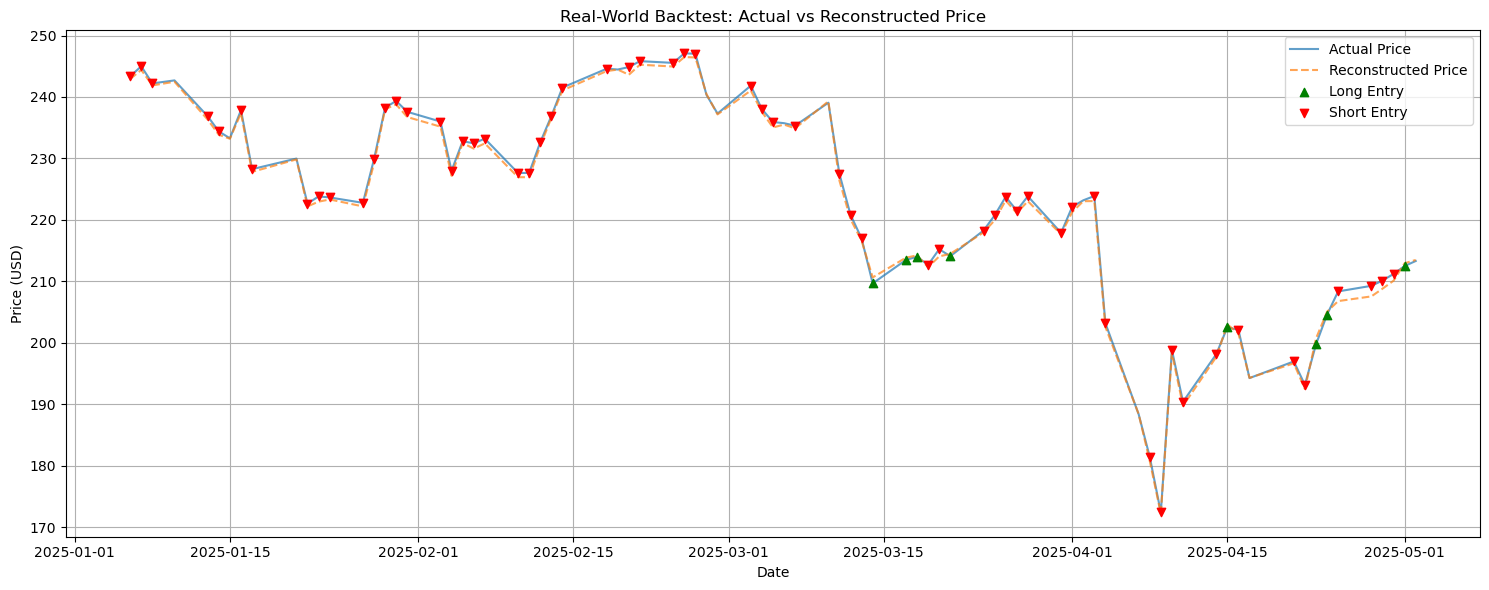

In [38]:
fig = long_short_position_graph(X_real, y_real_true, y_real_pred, positions)
